# Телеком — Поиск клиентов с неоптимальными тарифами

1. [Цель работы](#section_1)
2. [Загрузка и знакомство с данными](#section_2)
3. [Предподготовка данных](#section_3)
4. [Исследовательский анализ данных](#section_4)
5. [Проверка статистических гипотез](#section_5)
6. [Основные выводы исследования и рекомендации коммерческому департаменту](#section_6)

Материалы к проекту:  
[Презентация](https://disk.yandex.ru/i/BYLtvOgWlaKBKg)  
[Таблица со списком переплачивающих клиентов](https://disk.yandex.ru/i/MJVgINQHz_DJkw)  
[Дашборд](https://public.tableau.com/app/profile/dmitry2973/viz/telecom_analysis/telecom_board_1)

<a id='section_1'></a>
Коммерческий отдел оператора услуг виртуальной телефонии дал задание провести исследование своих клиентов. Необходимо найти клиентов, которые используют неоптимальные тарифные планы, переплачивают на своих тарифах и сэкономят, если перейдут на другой тариф. Это требуется, чтобы понять, что с ними нужно сделать, чтобы их не потерять. Также необходимо выяснить, насколько изменится средняя месячная выручка с клиентов, если переплачивающие клиенты перейдут на более выгодный тариф.  

Исследование делаем на основе двух датасетов. Первый датасет содержит данные об использовании услуг оператора виртуальной телефонии. Второй датасет это список клиентов компании с данными о тарифе и датой регистрации клиента в сервисе.

Описание данных:   
**Датасет `telecom_dataset`**:
- `user_id` — идентификатор клиента;
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.

**Датасет `telecom_clients`**:  
- `user_id` — идентификатор клиента;
- `tariff_plan` — тарифный план клиента;
- `date_start` — дата регистрации клиента в сервисе.

<a id='section_2'></a>
## 1. Загрузка и знакомство с данными

Для начала необходимо загрузить и изучить данные, проверить типы данных, возможные пропуски, разбросы значений в числовых полях, категориальные столбцы.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st 

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv', parse_dates=['date'])
display(data.head(7))
data.info()
data.describe()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [3]:
print('Значения столбца direction:', data['direction'].unique())

Значения столбца direction: ['in' 'out']


Данные требуют предварительной обработки, некоторые столбцы имеют неправильный тип данных, также имеются пропуски в двух столбцах. Во всех столбцах, касающихся звонков, имеются явные выбросы данных. Всё это проверим позже.

In [4]:
clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv', parse_dates=['date_start'])
display(clients.head(5))
clients.info()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


### Вывод
Загружено два датасета с данными, данные предварительно изучены. В датасете clients всё хорошо, с таблицей telecom_dataset требуется провести обработку данных.

<a id='section_3'></a>
## 2. Предподготовка данных
#### 2.1 Обработка типов данных

В колонке operator_id имеются пропущенные значения, поэтому тип данных там float. Остаётся только убрать часть со временем из столбца с датой.

In [5]:
data['date'] = data['date'].dt.date #обрезаем время
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT') #переводим обратно во формат время

В столбце *internal* тип данных object, но это скорее потому, что имеются пропущенные значения, которые будут обработаны в следующем пункте.

#### 2.2 Проверим данные на пропуски. Определимся, что делать с пропусками в каждом конкретном столбце.

In [6]:
print('Пропусков в столбце "internal"', data['internal'].isna().sum())
display(data[data['internal'].isna()].sample(5))
print('Направление вызовов в строках в пропусками:\n', data[data['internal'].isna()]['direction'].value_counts())

Пропусков в столбце "internal" 117


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
39519,167747,2019-10-18,in,NaN,NaN,True,1,0,8
29991,167272,2019-10-09,in,NaN,912684.0,False,1,123,175
44352,168041,2019-11-06,in,NaN,936514.0,False,1,1,24
52621,168361,2019-11-14,in,NaN,NaN,True,1,0,2
24509,167110,2019-11-08,in,NaN,NaN,True,2,0,9


Направление вызовов в строках в пропусками:
 in     115
out      2
Name: direction, dtype: int64


Почти все записи с пропущенными значениями "internal" - это входящие вызовы. Думаю, здесь лучше заменить их на False - будем считать эти вызовы как из внешней сети для будущих расчётов, чтобы не удалять данные.

In [7]:
data['internal'] = data['internal'].fillna(False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53902 non-null  bool          
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.0+ MB


Теперь изучим столбец 'operator_id' на пропуски. Посмотрим, сколько пропущенных значений здесь, какова средняя продолжительность вызовов.

In [8]:
 #смотрим характер числовых значений длительности и количества звонков в строках, где оператор не указан
display(data[data['operator_id'].isna()]['call_duration'].describe())
display(data[data['operator_id'].isna()]['total_call_duration'].describe())

count     8172.000000
mean        66.013828
std        954.840945
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26175.000000
Name: call_duration, dtype: float64

count     8172.000000
mean       233.756118
std       1252.370402
min          0.000000
25%          7.000000
50%         35.000000
75%        115.000000
max      42667.000000
Name: total_call_duration, dtype: float64

Пропущенных значений в столбце с оператором довольно много, и в подавляющем числе случаев это несостоявшиеся звонки. Есть и аномальные выбросы, с длительностью звонка до 26175 секунд. Удалять данные здесь не будем, так как при расчёте расходов учитывается время звонка с ожиданием, эти строки нам будут нужны. Заполнить пропущенные значения поля *operator_id* тоже не представляется возможным.  
Теперь найдём строки дубликаты в датафрейме.

In [9]:
print('Всего дубликатов в датафрейме:', data.duplicated().sum())
display(data[data.duplicated()].head(7))

Всего дубликатов в датафрейме: 4900


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05,out,False,880020.0,True,8,0,50
28,166377,2019-08-12,in,False,NaN,True,2,0,34
44,166377,2019-08-14,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14,in,False,NaN,True,1,0,3
51,166377,2019-08-15,out,False,880026.0,False,11,1413,1473
62,166377,2019-08-19,out,False,880026.0,False,14,1519,1598
78,166377,2019-08-22,out,False,880026.0,True,6,0,55


Полных дубликатов в таблице достаточно много - около десяти процентов. Для нашего исследования от них нужно избавится, чтобы получить точные расчёты.

In [10]:
data.drop_duplicates(inplace=True) #очищаем датафрейм от дубликатов

### Вывод

Данные обработаны, с некоторых столбцах типы данных приведены к нужному виду, изучены пропуски в данных, произведено заполнение пропусков в столбце internal.

<a id='section_4'></a>
## 3. Исследовательский анализ данных
### 3.1 Определим, за какой период у нас данные по использованию телефонии:


In [11]:
print(f'Начальная дата в датасете {data.date.min()}, конечная - {data.date.max()}.')

Начальная дата в датасете 2019-08-02 00:00:00, конечная - 2019-11-28 00:00:00.


### 3. 2 Изучение активности клиентов

In [12]:
print('Число уникальных клиентов:', data['user_id'].nunique())

Число уникальных клиентов: 307


Для изучения активности посмотрим все данные, не только за последний месяц. Пользователи могут пользоваться связью нерегулярно, месяц от месяца.

In [13]:
gr = data.groupby('user_id')['total_call_duration'].sum().reset_index() # агрегируем по пользователям для изучения
gr.describe()

,user_id,total_call_duration
count,307.000000,3.070000e+02
mean,167456.817590,1.846048e+05
std,612.584794,8.311251e+05
min,166377.000000,0.000000e+00
25%,166972.000000,1.248000e+03
50%,167455.000000,1.353800e+04
75%,167996.500000,1.033130e+05
max,168606.000000,1.183569e+07


Медиана здесь 13538 секунд за четыре месяца, это 56 минут за месяц. Неактивными буду считать тех, у кого менее 5 минут (300 секунд) звонков в общей сумме.

In [14]:
nausers = gr.query('total_call_duration < 300')['user_id'].unique() #список неактивных пользователей
print('Удалено неактивных пользователей:', len(nausers))
cdata = data.query('user_id not in @nausers') #очищаем данные от неактивных пользователей

Удалено неактивных пользователей: 34


### 3.3 Изучим данные на аномалии
Сначала изучим операторов - есть ли среди них такие, через которых совершается аномальное количество звонков за день.

In [15]:
gr_ops = data.groupby(['operator_id', 'date'])[['calls_count', 'total_call_duration']].sum()
display(gr_ops.describe())
print('Число уникальных операторов:', cdata['operator_id'].nunique(), 
      '\n95 и 99 перцентиль количества звонков в день на оператора', np.percentile(gr_ops['calls_count'], [95, 99]),
      '\n95 и 99 перцентиль продолжительности звонков в день на оператора', np.percentile(gr_ops['total_call_duration'], [95, 99]))

,calls_count,total_call_duration
count,19647.000000,19647.000000
mean,35.738026,2794.670688
std,114.219206,7970.731649
min,1.000000,0.000000
25%,2.000000,194.000000
50%,9.000000,868.000000
75%,32.000000,2910.000000
max,5022.000000,189989.000000


Число уникальных операторов: 1074 
95 и 99 перцентиль количества звонков в день на оператора [133. 347.] 
95 и 99 перцентиль продолжительности звонков в день на оператора [ 9633.7 23597.1]


Сразу видно, что имеются сильные выбросы в данных, аномальные значения количества звонков и суммы их продолжительности. Всё же, 99 процентов значений - это количество звонков в день через оператора меньше 400 при общей продолжительности 7,5 часов - вполне адекватные значения. Что считать аномальными значениями? Я предполагаю, что через оператора за 11 часов рабочей смены точно не может проходить больше 500 звонков, и продолжительность звонков за день быть больше 40000 секунд. Посмотрим, сколько таких операторов.

In [16]:
gr_ops.reset_index(inplace=True)
abnormal_operators = gr_ops.query('calls_count > 500 or total_call_duration > 40000')['operator_id'].unique().astype('int')
print(f'Список аномальных операторов: {abnormal_operators}, всего {len(abnormal_operators)}.')

Список аномальных операторов: [885876 885890 908640 925922 929424 929426 929428 945278 952948], всего 9.


У нас есть список аномальных операторов. Возможная причина того, что такие аномальные данные появились - это сбои системы, либо несколько узлов связи паралельно регистрировались в системе как один оператор.

Нужно выделить клиентов, которые обслуживаются этими аномальными операторами.

In [17]:
abnornal_clients = data.query('operator_id in @abnormal_operators')['user_id'].unique()
print(f'Список клиентов у аномальных операторов: {abnornal_clients}, всего {len(abnornal_clients)}.')

Список клиентов у аномальных операторов: [166582 167285 167827 168253 168361], всего 5.


In [18]:
#очищаем данные от клиентов, обслуживаемых у аномальных операторов
cdata = data.query('user_id not in @abnornal_clients')

### 3.4 Подсчёт ежемесячных расходов пользователей на связь в соответствии с их тарифами


In [19]:
#округлим даты до месяца, для дальнейшей группировки и подсчёта
cdata['month'] = cdata['date'].dt.to_period('M')
#исключаем все входящие звонки из таблицы, так как они бесплатны на всех тарифах
cdata = cdata.query('direction=="out"')
cdata

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,2019-08
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,2019-08
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,2019-08
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,2019-08
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,2019-08
...,...,...,...,...,...,...,...,...,...,...
53895,168606,2019-11-09,out,False,957922.0,False,4,551,593,2019-11
53896,168606,2019-11-10,out,True,957922.0,False,1,0,25,2019-11
53897,168606,2019-11-10,out,True,957922.0,True,1,0,38,2019-11
53898,168606,2019-11-11,out,True,957922.0,False,2,479,501,2019-11


In [20]:
#подсчёт уникальных операторов за каждый месяц
agr_operators = cdata.groupby(['user_id', 'month']).agg({'operator_id':'nunique'}).reset_index()
agr_operators.rename(columns = {'operator_id':'operators'}, inplace = True)
agr_operators.head(5)

,user_id,month,operators
0,166377,2019-08,5
1,166377,2019-09,4
2,166377,2019-10,5
3,166377,2019-11,4
4,166391,2019-08,1


In [21]:
#создаём отдельные колонки для звонков внутри сети и наружу, считаем минуты звонков с округлением вверх
internal_pivot = cdata.pivot_table(index=['user_id', 'month'], columns='internal', values = 'total_call_duration', aggfunc='sum')
internal_pivot.rename(columns = {True:'internal_minutes', False:'outer_minutes'}, inplace = True)
internal_pivot['internal_minutes'] = np.ceil(internal_pivot['internal_minutes']/60)
internal_pivot['outer_minutes'] = np.ceil(internal_pivot['outer_minutes']/60)
internal_pivot.reset_index(inplace = True)
internal_pivot['outer_minutes'] = internal_pivot['outer_minutes'].fillna(0)
internal_pivot['internal_minutes'] = internal_pivot['internal_minutes'].fillna(0)

In [22]:
#делаем общую агрегированную таблицу по пользователям за каждый месяц использования связи, присоединяем таблицу с наименованием текущего тарифа
pivot_users = internal_pivot.merge(agr_operators[['user_id','month', 'operators']], on=['user_id','month'], how='left')
pivot_users = pivot_users.merge(clients[['user_id','tariff_plan']], on='user_id', how='left')
pivot_users.head(5)

,user_id,month,outer_minutes,internal_minutes,operators,tariff_plan
0,166377,2019-08,1301.0,2.0,5,B
1,166377,2019-09,1764.0,1.0,4,B
2,166377,2019-10,1654.0,1.0,5,B
3,166377,2019-11,1590.0,3.0,4,B
4,166391,2019-08,0.0,1.0,1,C


Теперь у нас готова сводная таблица со всеми данными, нужными для подсчёта месячных расходов каждого пользователя в каждом месяце.  

Согласно данным из задачи,  
Ежемесячная плата за тариф:

- Тариф А — 5000 ₽,
- B — 2000 ₽,
- С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,  
**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7 ₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков. 

Задаём соответствующие значения в переменные.

In [23]:
rental_a = 5000 #абонентская плата тарифа А
rental_b = 2000 #абонентская плата тарифа B
rental_c = 1000 #абонентская плата тарифа C

internal_limit = 2000 #месячный лимит на исходящие звонки внутри сети в минутах
internal_a = 0.1 #цена за минуту исходящих вызовов внутри сети сверх лимита тарифа A
internal_b = 0.15 #цена за минуту исходящих вызовов внутри сети сверх лимита тарифа B
internal_c = 0.3 #цена за минуту исходящих вызовов внутри сети сверх лимита тарифа C

outer_a = 0.4 #цена за минуту остальных исходящих вызовов тарифа А
outer_b = 0.5 #цена за минуту остальных исходящих вызовов тарифа В
outer_c = 0.7 #цена за минуту остальных исходящих вызовов тарифа С

operator_price = 100 #цена за каждого уникального оператора в месяц

Для анализа тарифов сразу расчитаем расходы пользователей, на всех трёх тарифах - и поместим результаты в отдельные колонки таблицы.

In [24]:
# это функция, которая задаёт значения переменных, с зависимости от заданного тарифа
def tariff_price(tariff):
    if tariff == 'A':
        inter = internal_a #цена исходящей минуты внутри сети
        out = outer_a #цена исходящей минуты наружу
        rental = rental_a #фиксированная абонентская плата
        return inter, out, rental 
    if tariff == 'B':
        inter = internal_b
        out = outer_b
        rental = rental_b
        return inter, out, rental
    if tariff == 'C':
        inter = internal_c
        out = outer_c
        rental = rental_c
        return inter, out, rental
    else: 
        return 'tariff does not exist'

In [25]:
#функция непосредственно для расчёта расходов
def calculation(row):
    call_price=0
    if row['internal_minutes'] > internal_limit: #проверка на превышение лимита по минутам внутри сети
        call_price = (row['internal_minutes'] - internal_limit)*inter
    price = call_price + (row['outer_minutes'] * out) + rental + (row['operators']*operator_price) #сумма абонентской платы, платы за операторов, минут звонков внутри и снаружи сети
    return price

In [26]:
#применяем функции по очереди, добавляя результат в новые столбцы в таблице
inter, out, rental = tariff_price('A')
pivot_users['A'] = pivot_users.apply(calculation, axis=1)
inter, out, rental = tariff_price('B')
pivot_users['B'] = pivot_users.apply(calculation, axis=1)
inter, out, rental = tariff_price('C')
pivot_users['C'] = pivot_users.apply(calculation, axis=1)

In [27]:
#функция, добавляющая текущие расходы абонента по текущему тарифу
def current_earning(row):
    if row['tariff_plan'] == 'A':
        return row['A']
    if row['tariff_plan'] == 'B':
        return row['B']
    if row['tariff_plan'] == 'C':
        return row['C']

In [28]:
pivot_users['current_earning'] = pivot_users.apply(current_earning, axis=1)
#теперь выбираем из трёх тарифов самый дешёвый, результат колонка 'best_price'
pivot_users['best_price'] = pivot_users.apply(lambda row: min(row['A'], row['B'], row['C']), axis=1)
pivot_users.head(5)

,user_id,month,outer_minutes,internal_minutes,operators,tariff_plan,A,B,C,current_earning,best_price
0,166377,2019-08,1301.0,2.0,5,B,6020.4,3150.5,2410.7,3150.5,2410.7
1,166377,2019-09,1764.0,1.0,4,B,6105.6,3282.0,2634.8,3282.0,2634.8
2,166377,2019-10,1654.0,1.0,5,B,6161.6,3327.0,2657.8,3327.0,2657.8
3,166377,2019-11,1590.0,3.0,4,B,6036.0,3195.0,2513.0,3195.0,2513.0
4,166391,2019-08,0.0,1.0,1,C,5100.0,2100.0,1100.0,1100.0,1100.0


Финальная таблица почти готова - теперь найдем средние значения за все четыре месяца - сгруппируем данные по пользователям.

In [29]:
#функция, которая выводит название самого выгодного тарифа для пользователя
def best_tarif(row):
    if row['current_earning'] == row['best_price']: #если текущий тариф и так самый выгодный
        return 'CURRENT'
    if row['best_price'] == row['A']:
        return 'A'
    if row['best_price'] == row['B']:
        return 'B'
    if row['best_price'] <= row['C']:
        return 'C'

In [30]:
pivot_users['best_tarif'] = pivot_users.apply(best_tarif, axis=1)
pivot_users.head(5)

,user_id,month,outer_minutes,internal_minutes,operators,tariff_plan,A,B,C,current_earning,best_price,best_tarif
0,166377,2019-08,1301.0,2.0,5,B,6020.4,3150.5,2410.7,3150.5,2410.7,C
1,166377,2019-09,1764.0,1.0,4,B,6105.6,3282.0,2634.8,3282.0,2634.8,C
2,166377,2019-10,1654.0,1.0,5,B,6161.6,3327.0,2657.8,3327.0,2657.8,C
3,166377,2019-11,1590.0,3.0,4,B,6036.0,3195.0,2513.0,3195.0,2513.0,C
4,166391,2019-08,0.0,1.0,1,C,5100.0,2100.0,1100.0,1100.0,1100.0,CURRENT


Для каждого месяца здесь у нас расчитан наилучший тариф. Но прежде, чем предлагать новый тариф пользователям, надо быть уверенным, что он подходит им хорошо. Во-первых, если у пользователя ещё не установились обьемы пользования связью, смысла предлагать новый тариф нет. В список добавим только тех, кто пользуется связью большще двух месяцев. Также будем предлагать новый тариф, только если он выгоден им на протяжении всех месяцев пользования связью.

In [31]:
exclude = pivot_users.query('best_tarif == "CURRENT"')['user_id'].unique() #убираем тех, у кого в лучших хотя бы в одном месяце стоит текущий
final = pivot_users.query('user_id not in @exclude')
list_users = final.groupby(['user_id'])['month'].count().reset_index() #находим тех, кто пользуется сзяью больше 2 месяцев
list_users = list_users.query('month > 2')['user_id'].unique()
final = final.query('user_id in @list_users') #таблица final с клиентами, для которых есть лучшее предложение
final_pivot = pivot_users[['user_id', 'month', 'tariff_plan', 'A', 'B', 'C', 'current_earning']].merge(
    final[['user_id','month', 'best_tarif']], on=['user_id','month'], how='left') #соединяем с предыдущей таблицей
final_pivot.head(5)

,user_id,month,tariff_plan,A,B,C,current_earning,best_tarif
0,166377,2019-08,B,6020.4,3150.5,2410.7,3150.5,C
1,166377,2019-09,B,6105.6,3282.0,2634.8,3282.0,C
2,166377,2019-10,B,6161.6,3327.0,2657.8,3327.0,C
3,166377,2019-11,B,6036.0,3195.0,2513.0,3195.0,C
4,166391,2019-08,C,5100.0,2100.0,1100.0,1100.0,NaN


In [32]:
def calc2(row): # новая функция для расчёта суммы по лучшему тарифу
    if row['best_tarif'] == 'A':
        return row['A']
    if row['best_tarif'] == 'B':
        return row['B']
    if row['best_tarif'] == 'C':
        return row['C']
    return row['current_earning']

In [33]:
final_pivot['new_earning'] = final_pivot.apply(calc2, axis=1)
#таблица final_pivot с новыми расчитанными расходами пользователей с новыми тарифами
final_pivot['best_tarif'].fillna('Текущий', inplace=True)
final_grouped = final_pivot.groupby('user_id').agg( #считаем средний чек текущий и после смены тарифа части клиентов
    {'tariff_plan':'first', 'current_earning':'mean', 'best_tarif':'last', 'new_earning':'mean'}).reset_index() 
final_grouped.head(5)

,user_id,tariff_plan,current_earning,best_tarif,new_earning
0,166377,B,3238.625,C,2554.075
1,166391,C,1100.000,Текущий,1100.000
2,166405,B,4591.875,Текущий,4591.875
3,166406,B,3112.625,C,2467.675
4,166407,A,5638.300,C,1667.025


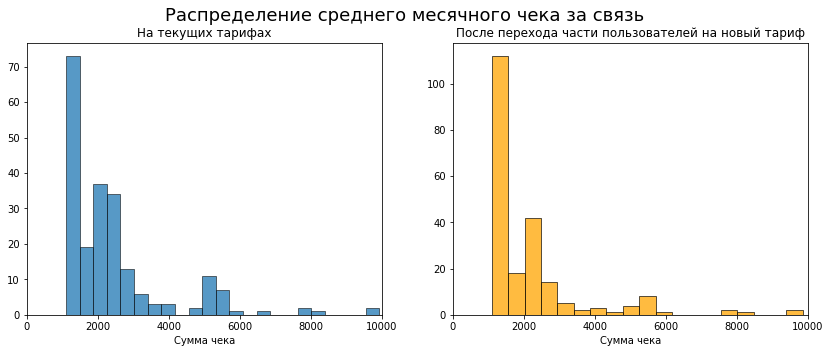

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Распределение среднего месячного чека за связь', fontsize=18)

sns.histplot(final_grouped, x='current_earning', ax=axes[0], bins=60)
axes[0].set_title('На текущих тарифах')
axes[0].set_xlabel('Сумма чека')
axes[0].set_ylabel('')
axes[0].set_xlim(0,10000)

sns.histplot(final_grouped, x='new_earning', color='orange', ax=axes[1], bins=50)
axes[1].set_title('После перехода части пользователей на новый тариф')
axes[1].set_xlabel('Сумма чека')
axes[1].set_ylabel('')
axes[1].set_xlim(0,10000)

plt.show()

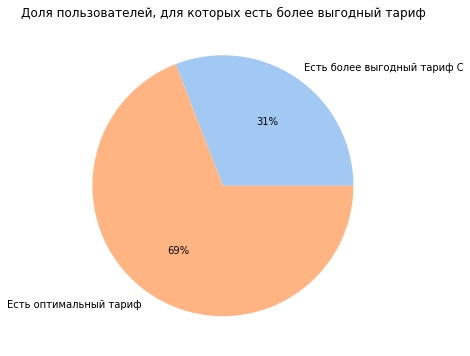

In [35]:
labels = ['Есть более выгодный тариф C', 'Есть оптимальный тариф']
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(8,6))
plt.pie(final_pivot.groupby('best_tarif').size(), labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Доля пользователей, для которых есть более выгодный тариф')
plt.show()

Треть клиентов переплачивает, интересно, что для всех этих клиентов выгоднее перейти на тариф "С". Сделаю наглядную таблицу по тарифам, сколько по каждому пользователей переплачивает, и на какой более выгодный могут перейти.

In [36]:
tarif_pivot = final_grouped.groupby(['tariff_plan', 'best_tarif']).agg({'user_id':'count', 'current_earning':'mean', 'new_earning':'mean'})
tarif_pivot['percent change'] = (((tarif_pivot['new_earning'] - tarif_pivot['current_earning']) / tarif_pivot['current_earning']) * 100).round(2)
tarif_pivot.rename(columns = {'user_id':'Количество клиентов', 'current_earning':'Текущий средний чек', 'new_earning':'Новый средний чек', 'percent change':'Изменение в процентах'}, inplace = True)
tarif_pivot.index.names = ['Текущий тариф', 'Новый более выгодный тариф']
display(tarif_pivot)

Количество клиентов  \
Текущий тариф Новый более выгодный тариф                        
A             C                                             8   
              Текущий                                      15   
B             C                                            38   
              Текущий                                      49   
C             Текущий                                     107   

                                          Текущий средний чек  \
Текущий тариф Новый более выгодный тариф                        
A             C                                   5478.441667   
              Текущий                             7779.453333   
B             C                                   2483.996711   
              Текущий                             2674.704082   
C             Текущий                             1574.675779   

                                          Новый средний чек  \
Текущий тариф Новый более выгодный тариф                      
A             C                                 1549.772917   
              Текущий                           7779.453333   
B             C                                 1568.823465   
              Текущий                           2674.704082   
C             Текущий                           1574.675779   

                                          Изменение в процентах  
Текущий тариф Новый более выгодный тариф                         
A             C                                          -71.71  
              Текущий                                      0.00  
B             C                                          -36.84  
              Текущий                                      0.00  
C             Текущий                                      0.00

Сохраним в отдельный файл таблицу со списком пользователей, которые переплачивают за связь, и могут перейти на более выгодный тариф.

In [37]:
clients_best_tarif = final_grouped.query('best_tarif !="Текущий"')
clients_best_tarif['Текущий уровень переплаты'] = (clients_best_tarif['current_earning'] - clients_best_tarif['new_earning']).round(2)
clients_best_tarif.rename(columns = {'user_id':'ID абонента', 
                                     'tariff_plan':'Текущий тарифный план', 
                                     'best_tarif':'Более выгодный тариф', 
                                     'current_earning':'Текущий средний чек',
                                     'new_earning':'Новый средний чек',}, inplace = True)
#clients_best_tarif.to_excel('clients_best_tarif.xlsx', sheet_name='list of clients', index=False)
clients_best_tarif.head(5)

,ID абонента,Текущий тарифный план,Текущий средний чек,Более выгодный тариф,Новый средний чек,Текущий уровень переплаты
0,166377,B,3238.625,C,2554.075,684.55
3,166406,B,3112.625,C,2467.675,644.95
4,166407,A,5638.300,C,1667.025,3971.27
5,166485,B,3343.750,C,2711.250,632.50
7,166495,B,2549.125,C,1708.775,840.35


### Подсчёт месячной выручки с пользователей
Теперь у нас есть список пользователей, которым было бы выгодно перейти на новый тариф. Посчитаем среднюю выручку со всех пользователей, с текущими тарифами, и с новыми.

,Месяц,Текущая выручка с клиентов,Выручка после смены тарифов,Изменение в процентах
0,2019-08,112276.6,80718.2,-28.11
1,2019-09,293161.8,225856.0,-22.96
2,2019-10,447209.6,382722.0,-14.42
3,2019-11,468100.0,404903.8,-13.50


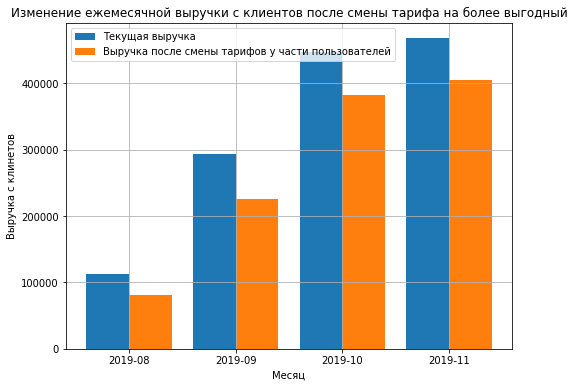

In [38]:
#формирую таблицу по общей месячной выручке с пользователей
tab = final_pivot.groupby('month')[['current_earning', 'new_earning']].sum().reset_index()
tab['month'] = tab['month'].dt.to_timestamp('s').dt.strftime('%Y-%m')
tab['percent change'] = (((tab['new_earning'] - tab['current_earning']) / tab['current_earning']) * 100).round(2)
tab.rename(columns = {'month':'Месяц', 
                      'current_earning':'Текущая выручка с клиентов', 
                      'new_earning':'Выручка после смены тарифов',
                      'percent change':'Изменение в процентах',}, inplace = True)
display(tab) 
#диаграмма, показывающая изменение выручки
plt.figure(figsize=(8,6))
x_axis = np.arange(len(tab['Месяц']))
plt.grid(zorder=0)
plt.bar(x_axis -0.2, tab['Текущая выручка с клиентов'], width=0.4, label = 'Текущая выручка')
plt.bar(x_axis +0.2, tab['Выручка после смены тарифов'], width=0.4, label = 'Выручка после смены тарифов у части пользователей')
plt.xticks(x_axis, tab['Месяц'])
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Выручка с клинетов')
plt.title('Изменение ежемесячной выручки с клиентов после смены тарифа на более выгодный')
plt.show()

Если учитывать только последние два месяца с полноценными объёмами пользования связью, падение выручки после смены тарифов у части клиентов составляет около 14 процентов. Учитываем, что пока круг тех, кому предлагается сменить тариф ограничен теми, кто пользуется связью больше трёх месяцев, у кого уже примерно установились объёмы пользования сервисом. В дальнейших наблюдениях круг переплачивающих может расширится, если текущие условия тарифов останутся неизменными.

<a id='section_5'></a>
## Проверка статистических гипотез

### Посчитаем статистическую значимость различий в среднем чеке пользователей переплачивающих за связь, и пользователей, перешедших на новый выгодный тариф.

Нулевой гипотезой будет, что средний чек будет одинаковым. Для проверки я буду использовать метод st.ttest_rel, с помощью которой проверяют гипотезы о равестве средних для зависимых (парных) выборок. В нашем случае равно ли себе среднее этой совокупности до и после изменения тарифов. Уровень значимости я выбрал 5 процентов, чтобы немного снизить вероятность ошибки ложноотрицательного результата, но брать ещё ниже в случае рассмотрения именно разницы средних чеков считаю нецелесообразно, так как это несущественная разница.

In [39]:
print('Средняя выручка с пользователя в месяц на текущих тарифах:',
      final_pivot["current_earning"].mean(), '\nДисперсия:', np.var(final_pivot["current_earning"]), 
      '\nСтандартное отклонение:', np.std(final_pivot["current_earning"]))
print('\nПри переходе на части пользователей на новые тарифы:',
      final_pivot["new_earning"].mean(), '\nДисперсия:', np.var(final_pivot["new_earning"]), 
      '\nСтандартное отклонение:', np.std(final_pivot["new_earning"]))

Средняя выручка с пользователя в месяц на текущих тарифах: 2615.342574257426 
Дисперсия: 4996768.718405255 
Стандартное отклонение: 2235.3453241960747

При переходе на части пользователей на новые тарифы: 2166.732673267327 
Дисперсия: 4714601.000655231 
Стандартное отклонение: 2171.3131972737674


In [40]:
alpha = 0.05 #задаём стандартное пороговое значение
#применяем метод scipy.stats.ttest_rel() для проверки гипотезы о равенстве среднего двух генеральных совокупностей 
results = st.ttest_rel(final_pivot["current_earning"], 
                       final_pivot["new_earning"]) #так как дисперсии совокупностей не равны
print('P-value:', results.pvalue)

if (results.pvalue < alpha): #если pvalue меньше уровня критической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 1.4762265061318854e-24
Отвергаем нулевую гипотезу


Это значит, что подтвержается наше предположение, что средний чек значительно упадёт после того, как часть пользователей уйдёт на более выгодный тариф.

### Cравнение средних чеки тех, кто перейдёт на новые, более выгодные тарифы, и тех, кто и так на самом оптимальном тарифе. Нулевая гипотеза - средний чек будет одинаковым.

In [41]:
alpha = 0.05 #задаём стандартное пороговое значение
#применяем метод scipy.stats.ttest_rel() для проверки гипотезы о равенстве среднего двух генеральных совокупностей 
results = st.ttest_ind(final_pivot.query('best_tarif != "Текущий"')["new_earning"], 
                       final_pivot.query('best_tarif == "Текущий"')["new_earning"], equal_var=False) #так как дисперсии совокупностей не равны
print('P-value:', results.pvalue)

if (results.pvalue < alpha): #если pvalue меньше уровня критической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 7.013425783537761e-09
Отвергаем нулевую гипотезу


Нулевая гипотеза и здесь отвернута. Средние чеки людей, которые имеют уже оптимальные тарифы, выше. Во-первых, это конечно, связано с тем, что абонентская плата на тарифах А и B значительно выше, во-вторых, как правило, это те, кто гораздо чаще пользуется связью.

<a id='section_6'></a>
## Основные выводы исследования и рекомендации коммерческому департаменту

В ходе данной работы были изучены два датасета данных - логи использования сервиса виртуальной телефонии, и таблица с тарифами клиентов. Прежде чем проводить исследовательский анализ данных, данные были предобработаны, изменены некоторые типы данных, проверены и обработаны пропуски. Также данные были проверены на аномалии, выделен список аномальных операторов, через которых севершается слишком большое количество звонков в день. Этот список можно передать для проверки в технический отдел. Возможно проблема в регистрации нескольких человек под одной учётной записью. Выделено также некоторое количество аномальных клиентов - для точности нашего дальнейшего анализа этих клиентов я удалил из исследования. Также из очищенного датафрейма удалил некоторых неактивных пользователей, которые практически не пользовались связью в период исследования.  
Для расчёта ежемесячных расходов пользователей за связь я сформировал сводные таблицы со всеми требуемыми данными. Для сравнения я посчитал возможные расходы пользователей на каждом из трёх тарифов. 

Сравнив текущие расходы пользователей, я выделил список в 46 переплачивающих клиентов, которым мы можем предложить более выгодный тариф. На тарифе "А" из 23 активных клинентов для восьми выгоднее уйти на тариф "C", на него же выгоднее уйти 40 процентам абонентов на тарифе "В".
Почему самый выгодный для них выходит "С"? У него самая низкая абонентская плата, разница в стоимости минуты разговора по сравнению с другими тарифами не так велика.
Нужно учесть, что я не включил часть пользователей, которые сейчас переплачивают, но пользуются связью совсем недавно. Возможно, они ещё не вышли на свои объёмы пользования связью. Если же их уровень активности останется такой же, их тоже можно записывать в переплачивающие, и тогда наш список значительно расширится.

Посчитал ежемесячную выручку со всех пользователей на текущих тарифах, и после перехода части пользователей на новый тариф. Падение выручки после смены тарифа на основе данных последних месяцев составляет около 14 процентов. Средний чек у перешедших с тарифа А упадёт на 70 процентов, перешедших с тарифа В - на 36 процентов. В списке пользователей, который я прилагаю к этому исследованию, указан текущий средний чек, новый средний чек, и разница между ними.

Чтобы избежать риска падения выручки, нужно в первую очередь переработать условия тарифов. У них у всех одинаковые лимиты на минуты в месяц - для  более дорогих тарифов их можно оставить такими, как есть, для более дешёвого тарифа - понизить. Стоимость минуты разговора на дорогих тарифах можно снизить, также, возможно, для более дорогих тарифов можно убрать или снизить плату за уникальных операторов - тогда люди будут намного меньше переплачивать. И сам размер абонентской платы на дорогом тарифе будет более оправдан. Сейчас ежемесячная абонентская плата и цена минут разговора совсем не делают дорогие тарифы привлекательными для большей части клиентов.

In [42]:
#data.to_csv('tececom_edited.csv', index=False) #выгрузка обработанного датасета для дашборда